In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [3]:
localpath = 'D:/leeky_ai/대회/건설기계오일/open/'

In [4]:
train = pd.read_csv(localpath+"train.csv")
test =  pd.read_csv(localpath+"test.csv")

In [5]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [6]:
train = train.fillna(0)
test = test.fillna(0)

<AxesSubplot:>

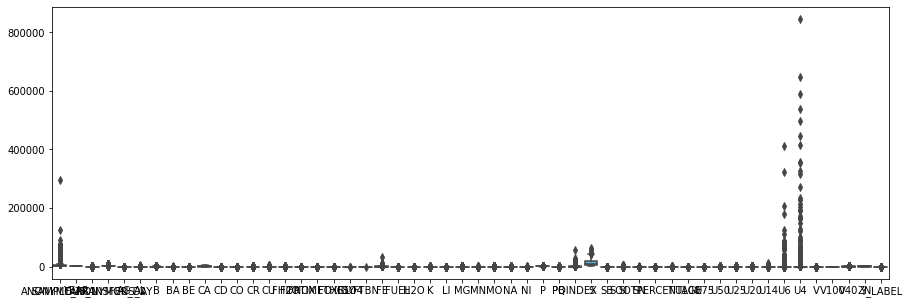

In [7]:
# train.describe()
plt.figure(figsize=(15,5))
sns.boxplot(data = train)

In [8]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


In [9]:
from sklearn.model_selection import train_test_split
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
test = test.drop(['ID'], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [10]:
train_X.shape , val_X.shape, train_y.shape, val_y.shape

((11276, 52), (2819, 52), (11276,), (2819,))

In [11]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = RobustScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [12]:
test.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,0,-0.014439,9,0.0,0.0,0.0,-0.333333,-0.1875,-0.232,0.0,-0.5,-0.142857,0.0,-0.105882,0.0,0.0,-0.305215,0.527290
1,2,0.265952,4,0.0,0.0,0.0,0.333333,-0.1875,1.896,0.0,1.0,-0.142857,0.0,15.905882,1.0,0.0,0.240798,-0.470860
2,1,-0.112250,3,0.0,0.0,0.0,-0.333333,0.7500,-0.288,0.0,-0.5,-0.142857,0.0,-0.100000,0.0,0.0,-1.026074,0.178538
3,2,-0.381463,2,0.0,0.0,0.0,0.666667,0.0000,0.976,0.0,1.5,0.285714,0.0,46.935294,0.0,0.0,0.484663,-0.395005
4,1,2.795529,6,0.0,0.0,0.0,-0.333333,0.1250,-0.224,0.0,-0.5,-0.142857,0.0,-0.070588,0.0,0.0,-0.733129,-0.048104


# 지식증류(Knowledge Distillation)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras

In [14]:
train_X.shape

(11276, 52)

In [17]:
# 교사 모델 생성
teacher = keras.Sequential(
    [
    keras.Input(shape=(52,))
    ,layers.Dense(256)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1024)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(256)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1)
    ,layers.BatchNormalization()    
    ,layers.Activation(activation='sigmoid')
    ],
    name = 'teacher'
)

In [16]:
# 학생 모델 생성
student = keras.Sequential(
    [
    keras.Input(shape=(18,))
    ,layers.Dense(128)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(512)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(128)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1)
    ,layers.BatchNormalization()    
    ,layers.Activation(activation='sigmoid')
    ],
    name = 'student'
)

In [18]:
# # 교사모델 훈련
# teacher.compile(
#     optimizer=keras.optimizers.Adam()
#     ,loss = keras.losses.binary_crossentropy
#     ,metrics=['acc']
# )
# callback = [
#     keras.callbacks.EarlyStopping(patience = 7),
#     keras.callbacks.ModelCheckpoint('teacher.model.keras',save_best_only=True)
# ]
# teacher.fit(train_X,train_y,epochs=100,callbacks=callback, validation_data=(val_X,val_y))
# teacher_loadmodel = keras.models.load_model('teacher.model.keras')
# teacher_loadmodel.evaluate(val_X,val_y)

In [19]:
student_train_X =   train_X.loc[:,test_stage_features]
student_val_X = val_X.loc[:,test_stage_features]
student_train_X.shape, train_y.shape, student_val_X.shape, val_y.shape

((11276, 18), (11276,), (2819, 18), (2819,))

In [20]:
# 학생모델 훈련
student.compile(
    optimizer=keras.optimizers.Adam()
    ,loss = keras.losses.binary_crossentropy
    ,metrics=['acc']
)
callback = [
    keras.callbacks.EarlyStopping(patience = 7),
    keras.callbacks.ModelCheckpoint('student.model.keras',save_best_only=True)
]
student.fit(student_train_X,train_y,epochs=100,callbacks=callback, validation_data=(student_val_X,val_y))
student_loadmodel = keras.models.load_model('student.model.keras')
student_loadmodel.evaluate(student_val_X,val_y)

Epoch 1/100
353/353 [==============================] - 3s 4ms/step - loss: 0.6888 - acc: 0.5827 - val_loss: 0.6066 - val_acc: 0.8414
Epoch 2/100
353/353 [==============================] - 1s 4ms/step - loss: 0.5400 - acc: 0.8081 - val_loss: 0.4804 - val_acc: 0.8954
Epoch 3/100
353/353 [==============================] - 1s 4ms/step - loss: 0.4493 - acc: 0.8897 - val_loss: 0.4221 - val_acc: 0.9081
Epoch 4/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3929 - acc: 0.9092 - val_loss: 0.3751 - val_acc: 0.9110
Epoch 5/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3561 - acc: 0.9137 - val_loss: 0.3461 - val_acc: 0.9124
Epoch 6/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3306 - acc: 0.9147 - val_loss: 0.3227 - val_acc: 0.9138
Epoch 7/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3129 - acc: 0.9147 - val_loss: 0.3115 - val_acc: 0.9131
Epoch 8/100
353/353 [==============================] - 1s 4ms/step - 

[0.2794610857963562, 0.913444459438324]

In [21]:
preds = student_loadmodel.predict(test)
preds

189/189 [==============================] - 0s 1ms/step


array([[0.05209689],
       [0.10687969],
       [0.10435835],
       ...,
       [0.10186332],
       [0.04768187],
       [0.04109691]], dtype=float32)

In [22]:
np.unique(np.round(preds),return_counts=True)

(array([0., 1.], dtype=float32), array([6036,    5], dtype=int64))

In [25]:
submit = pd.read_csv(localpath+'/sample_submission.csv')
submit['Y_LABEL'] = np.round(preds)
submit.to_csv(localpath+'/submit.csv', index=False)

In [24]:
localpath

'D:/leeky_ai/대회/건설기계오일/open/'

In [31]:
# 1.pca를 이용해서 차원을 축소... 차수를 맞춘다.
from sklearn.decomposition import PCA
pca = PCA(n_components=18)
pca_train_x =  pca.fit_transform(train_X)
pca_val_x = pca.fit_transform(val_X)

In [32]:
pca_train_x.shape, pca_val_x.shape,test.shape

((11276, 18), (2819, 18), (6041, 18))

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

In [50]:
# 랜덤 포레스트 모델을 만듭니다. 
rf = RandomForestClassifier(n_estimators=10, random_state=32, n_jobs=-1)

In [35]:
# 교차 검증을 수행합니다.
scores = cross_val_score(rf, pca_train_x, train_y, cv=5)

In [38]:
print(f"정확도 : {np.round(scores,3)}")
print(f"정확도 평균 : {np.mean(scores):.3f}")

정확도 : [0.95  0.952 0.953 0.95  0.947]
정확도 평균 : 0.951


In [51]:
rf.fit(pca_train_x, train_y)
predict = rf.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.8797445902802412
정밀도 : 0.31950207468879666
재현율 : 0.3055555555555556
f1_score : 0.31237322515212984


In [53]:
from sklearn.tree import DecisionTreeClassifier
dtc= DecisionTreeClassifier(max_depth=3)
dtc.fit(pca_train_x,train_y)
predict = dtc.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.8850656261085491
정밀도 : 0.34024896265560167
재현율 : 0.3319838056680162
f1_score : 0.33606557377049184


In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =  GradientBoostingClassifier(max_depth=2,n_estimators=3, random_state=2, learning_rate=1.0)
gbc.fit(pca_train_x,train_y)
predict = gbc.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.8854203618304364
정밀도 : 0.34024896265560167
재현율 : 0.3333333333333333
f1_score : 0.33675564681724846


In [57]:
# 튜닝
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[300, 500, 1000],
          'learning_rate':[0.05, 0.075, 0.1]}
from sklearn.model_selection import RandomizedSearchCV
rand_reg = RandomizedSearchCV(gbc,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=2)
rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                        max_depth=2,
                                                        n_estimators=3,
                                                        random_state=2),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.075, 0.1],
                                        'n_estimators': [300, 500, 1000],
                                        'subsample': [0.65, 0.7, 0.75]},
                   random_state=2, scoring='neg_mean_squared_error', verbose=2)

In [59]:
# rand_reg.best_estimator_
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.884710890386662
정밀도 : 0.34439834024896265
재현율 : 0.332
f1_score : 0.33808553971486766


In [63]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [64]:
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.075, 0.1],
                                        'n_estimators': [300, 500, 1000],
                                        'subsample': [0.65, 0.7, 0.75]},
                   random_state=2, scoring='neg_mean_squared_error', verbose=1)

In [65]:
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.8932245477119546
정밀도 : 0.25311203319502074
재현율 : 0.33516483516483514
f1_score : 0.28841607565011823


In [71]:
xgb = XGBClassifier(booster='gbtree', max_depth=6,objective='binary:logistic'
              ,learning_rate=0.1, n_estimators=100,n_jobs=-1)
xgb.fit(pca_train_x,train_y)
predict = xgb.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.8854203618304364
정밀도 : 0.33195020746887965
재현율 : 0.3305785123966942
f1_score : 0.33126293995859213


In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_train_x =  pca.fit_transform(train_X)
pca_val_x = pca.fit_transform(val_X)
pca_test = pca.fit_transform(test)
xgb = XGBClassifier(booster='gbtree', max_depth=6,objective='binary:logistic'
              ,learning_rate=0.1, n_estimators=100,n_jobs=-1)
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1, max_bin=No...
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.5],
                                        'max_depth': [2, 3, 5, 6, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         800],
                                        'subsample': [0.65, 0.7, 0.75]},
                   random_state=2, scoring='neg_mean_squared_error', verbose=1)

In [81]:
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.9145086910251863
정밀도 : 0.0
재현율 : 0.0
f1_score : 0.0


C:\Users\user\miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
xgb = XGBClassifier(booster='gbtree', max_depth=6,objective='binary:logistic'
              ,learning_rate=0.1, n_estimators=100,n_jobs=-1)
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(train_X,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1, max_bin=No...
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.5],
                                        'max_depth': [2, 3, 5, 6, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         800],
                                        'subsample': [0.65, 0.7, 0.75]},
                   random_state=2, scoring='neg_mean_squared_error', verbose=1)

In [87]:
predict = rand_reg.best_estimator_.predict(val_X)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.952465413267116
정밀도 : 0.4979253112033195
재현율 : 0.9022556390977443
f1_score : 0.6417112299465241


In [91]:
train_X.shape, test.shape

((11276, 52), (6041, 18))

<BarContainer object of 52 artists>

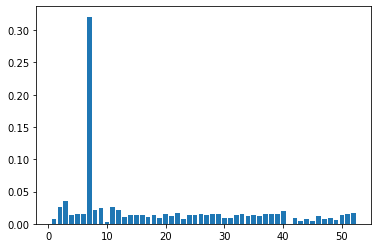

In [95]:
plt.bar(x = range(1,53),height=rand_reg.best_estimator_.feature_importances_)

In [100]:
sort_index = np.argsort( rand_reg.best_estimator_.feature_importances_)
sort_index[::-1][:18]

array([ 6,  2,  1, 10,  8,  7, 11, 39, 51, 21, 38, 28, 37, 19,  5, 50, 27,
        4], dtype=int64)

In [ ]:
temp_x = train_X.iloc[:,sort_index[::-1][:18]]
temp_val = val_X.iloc[:,sort_index[::-1][:18]]
xgb = XGBClassifier(booster='gbtree', max_depth=6,objective='binary:logistic'
              ,learning_rate=0.1, n_estimators=100,n_jobs=-1)
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(temp_x,train_y)
predict = rand_reg.best_estimator_.predict(temp_val)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
